In [1]:
import torch
import timm
import openslide

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login

import matplotlib.pyplot as plt

In [2]:
# Determine the device to run the model on (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Read the huggingface token from a file
with open("huggingface_token.key", "r") as f:
    token = f.read()

# Login to huggingface hub with the token
login(token)

In [4]:
# pretrained=True needed to load UNI2-h weights (and download weights for the first time)
timm_kwargs = {
            'model_name': 'hf-hub:MahmoodLab/UNI2-h',
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }

# Create the model
model = timm.create_model(pretrained=True, **timm_kwargs)

# Put the model on the device
model = model.to(device)

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.73G [00:00<?, ?B/s]

In [5]:
# Create the transform function from the model config
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
transform

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

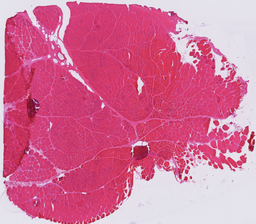

In [6]:
# Determine the slide id
slide = "tissue_crop_4352_30208"

# Load the slide with openslide
slide = openslide.OpenSlide(f"/workspaces/WSI-Classification/data/HE-MYO/Processed/Dystrophic/{slide}.ome.tiff")

# Make a thumbnail of the slide
slide.get_thumbnail(size=(256, 256))

In [7]:
# Read a 512*512 tile image of the slide
tile = slide.read_region(location=(2000, 2000), level=0, size=(448, 448))

# Convert to RGB
tile = tile.convert("RGB")

# Transform the image to the model suitable input tensor
image = transform(tile).unsqueeze(dim=0).to(device)

# Extracted features (torch.Tensor) with shape [1,1536]
with torch.inference_mode():
    feature_emb = model(image) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431373..2.1804092].


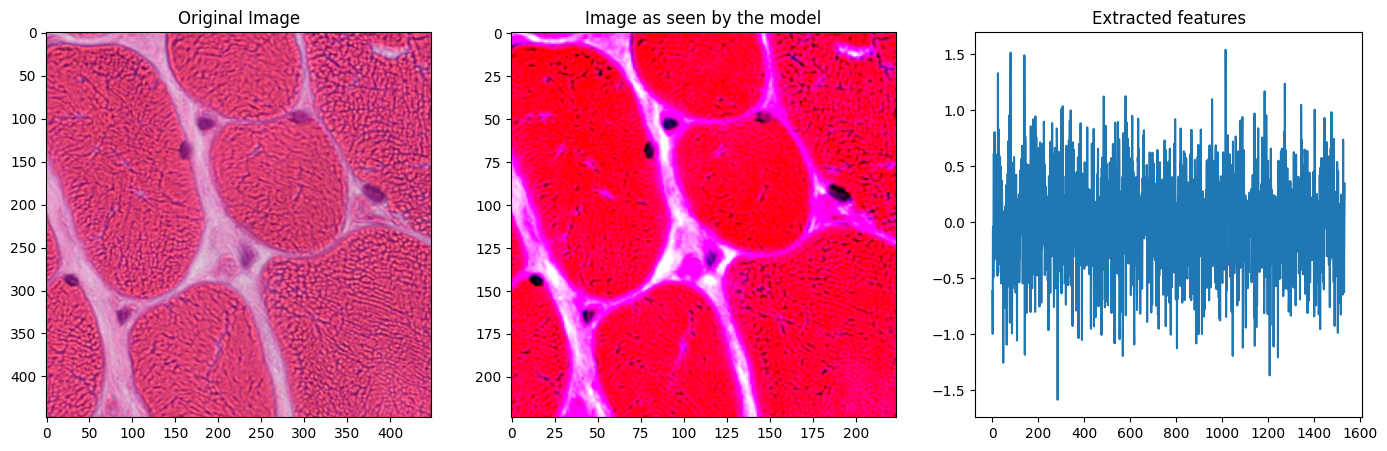

In [8]:
# Plot both the original image and the image seen by the model
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax[0].imshow(tile)
ax[0].set_title("Original Image")

ax[1].imshow(image.cpu().squeeze().permute(1, 2, 0))
ax[1].set_title("Image as seen by the model")

ax[2].plot(feature_emb.cpu().squeeze().detach().numpy())
ax[2].set_title("Extracted features")

plt.show()